# Validation

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error
import math
    
import mydata
import performance
from F1AUC import PerformanceMeasure, PerformanceOptimisation
from bayes import BayesianRegression

In [2]:
db = ["UTKFace", "CelebA", "HAM"]
df = pd.DataFrame()
models = None
length_db = {}

for i in range(len(db)):
    root = f"../../dataset/AAAI 2025/{db[i]}/"
    filepaths = {"EFF": f"{root}evaluation/df_valid_efficientnet.csv", 
                 "RES": f"{root}evaluation/df_valid_resnet.csv", "VGG": f"{root}evaluation/df_valid_vgg.csv"}
    models = list(filepaths.keys())
    
    for k, v in filepaths.items():
        tmp = mydata.uniformdataload(v, True)
        tmp["model"] = k
        tmp["db"] = db[i]
        if k == "EFF":
            length_db[db[i]] = len(tmp)
        df = pd.concat([df, tmp])

In [3]:
df_scores = pd.DataFrame()
df_corr = pd.DataFrame()

for d in range(len(db)):
    for m in range(len(models)):
        pm = PerformanceMeasure(df[(df["db"] == db[d]) & (df["model"] == models[m])], "distance")
        b_start = 10
        b_end = 310
        b_step = 10
        for i in range(b_start, b_end, b_step):
            # batch
            tmp = pm.measure(i)
            tmp["batch size"] = i
            tmp["model"] = models[m]
            tmp["db"] = db[d]
            df_scores = pd.concat([df_scores, tmp])
            # Correlation
            tmp = tmp[["distance", "F1", "ACC"]].corr()
            F1 = tmp.at["distance", "F1"]
            ACC = tmp.at["distance", "ACC"]
            dic = {"F1": F1, "ACC": ACC, "batch": i, "model": models[m], "db": db[d]}
            df_corr = pd.concat([df_corr, pd.DataFrame([dic])])

/home/kuniko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuniko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


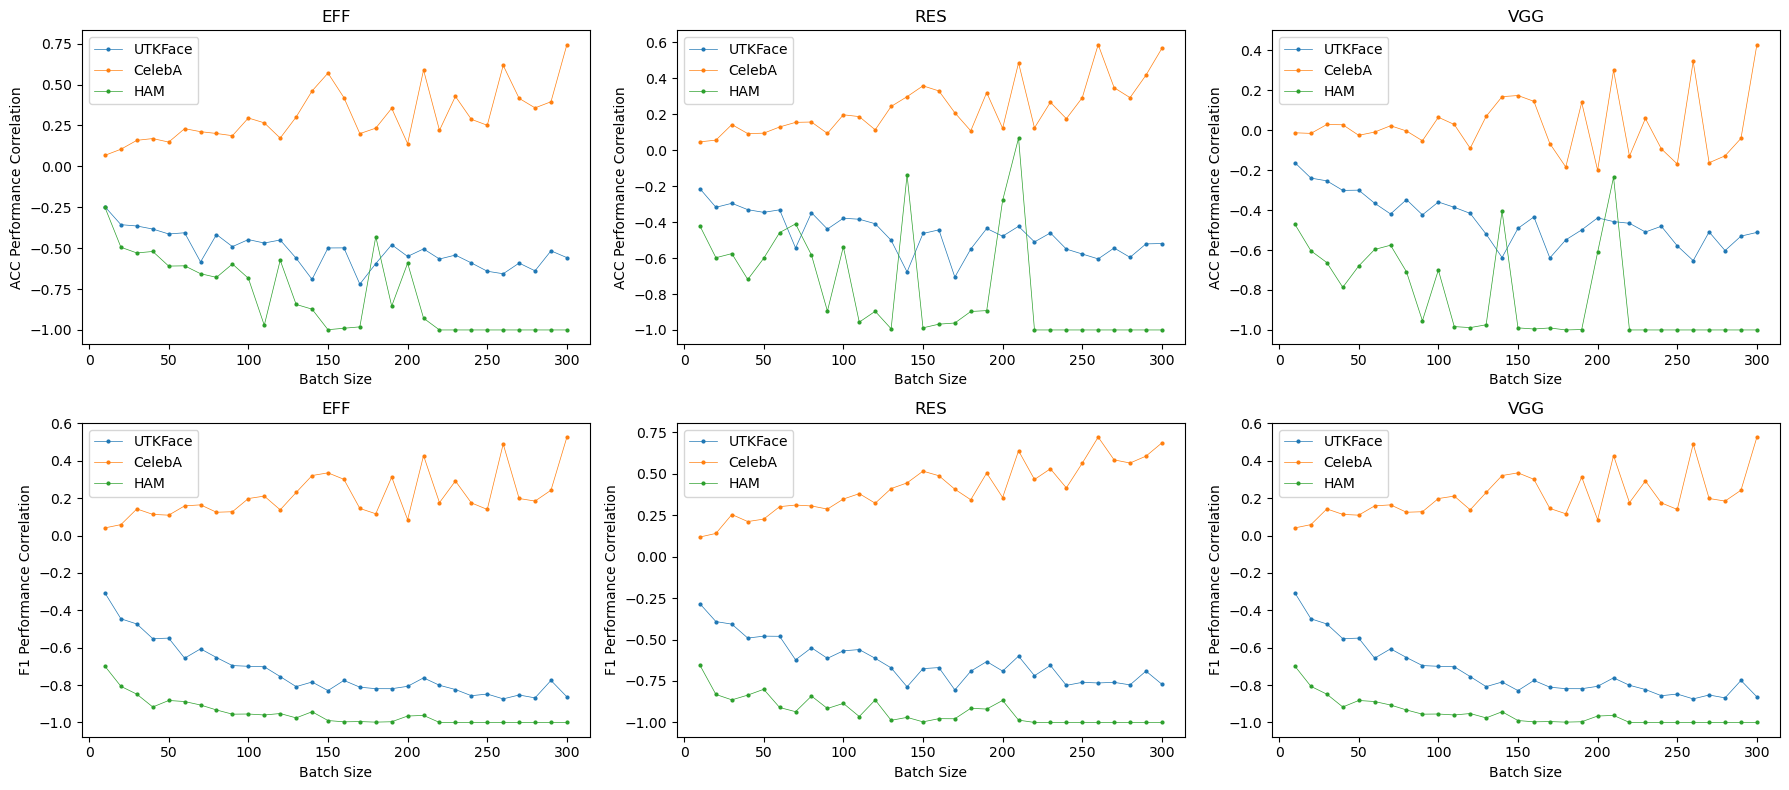

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for i in range(len(db)):
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "EFF")]
    ax[0, 0].plot(subset["batch"], subset["ACC"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[0, 0].set_title(f"EFF")
    ax[0, 0].set_xlabel("Batch Size")
    ax[0, 0].set_ylabel("ACC Performance Correlation")
    ax[0, 0].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "RES")]
    ax[0, 1].plot(subset["batch"], subset["ACC"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[0, 1].set_title(f"RES")
    ax[0, 1].set_xlabel("Batch Size")
    ax[0, 1].set_ylabel("ACC Performance Correlation")
    ax[0, 1].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "VGG")]
    ax[0, 2].plot(subset["batch"], subset["ACC"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[0, 2].set_title(f"VGG")
    ax[0, 2].set_xlabel("Batch Size")
    ax[0, 2].set_ylabel("ACC Performance Correlation")
    ax[0, 2].legend()

    ax[1, 0].plot(subset["batch"], subset["F1"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[1, 0].set_title(f"EFF")
    ax[1, 0].set_xlabel("Batch Size")
    ax[1, 0].set_ylabel("F1 Performance Correlation")
    ax[1, 0].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "RES")]
    ax[1, 1].plot(subset["batch"], subset["F1"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[1, 1].set_title(f"RES")
    ax[1, 1].set_xlabel("Batch Size")
    ax[1, 1].set_ylabel("F1 Performance Correlation")
    ax[1, 1].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "VGG")]
    ax[1, 2].plot(subset["batch"], subset["F1"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[1, 2].set_title(f"VGG")
    ax[1, 2].set_xlabel("Batch Size")
    ax[1, 2].set_ylabel("F1 Performance Correlation")
    ax[1, 2].legend()

plt.tight_layout()
plt.show()

In [5]:
df_results = pd.DataFrame()
for i in range(len(db)):
    for j in range(len(models)):
        batch_size = math.ceil(length_db[db[i]] * 0.01)
        batch_size = math.ceil(batch_size / 10) * 10
        #print(batch_size)
        subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == models[j]) & (df_corr["batch"] == batch_size)]
        df_results = pd.concat([df_results, subset])

In [6]:
length_db

{'UTKFace': 2384, 'CelebA': 2134, 'HAM': 434}

In [7]:
df_results

,F1,ACC,batch,model,db
0,-0.481659,-0.364656,30,EFF,UTKFace
0,-0.407145,-0.295296,30,RES,UTKFace
0,-0.473233,-0.253765,30,VGG,UTKFace
0,0.249856,0.158819,30,EFF,CelebA
0,0.253884,0.142710,30,RES,CelebA
0,0.142209,0.028354,30,VGG,CelebA
0,-0.308588,-0.251484,10,EFF,HAM
0,-0.655582,-0.422052,10,RES,HAM
0,-0.699392,-0.471714,10,VGG,HAM


# Performance Estimation with Bayesian Regression

In [9]:
import os

for i in range(len(db)):
    folder_path = f"../../dataset/AAAI 2025/{db[i]}/estimator"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"{folder_path} was created")
    else:
        print(f"{folder_path} already exists")

../../dataset/AAAI 2025/UTKFace/estimator already exists
../../dataset/AAAI 2025/CelebA/estimator already exists
../../dataset/AAAI 2025/HAM/estimator already exists


In [10]:
df_scores

,distance,F1,ACC,batch size,model,db
0,-80.598214,0.857143,0.800000,10,EFF,UTKFace
1,-68.789223,0.941176,0.900000,10,EFF,UTKFace
2,-63.978800,1.000000,1.000000,10,EFF,UTKFace
3,-62.177884,0.941176,0.900000,10,EFF,UTKFace
4,-59.805212,0.933333,0.900000,10,EFF,UTKFace
...,...,...,...,...,...,...
1,47.906569,0.632653,0.766234,280,VGG,HAM
0,5.187817,0.876623,0.868966,290,VGG,HAM
1,49.101261,0.638298,0.763889,290,VGG,HAM
0,6.086821,0.872611,0.866667,300,VGG,HAM


Modle saved
Modle saved
Modle saved
Modle saved
Modle saved
Modle saved
Modle saved
Modle saved
Modle saved


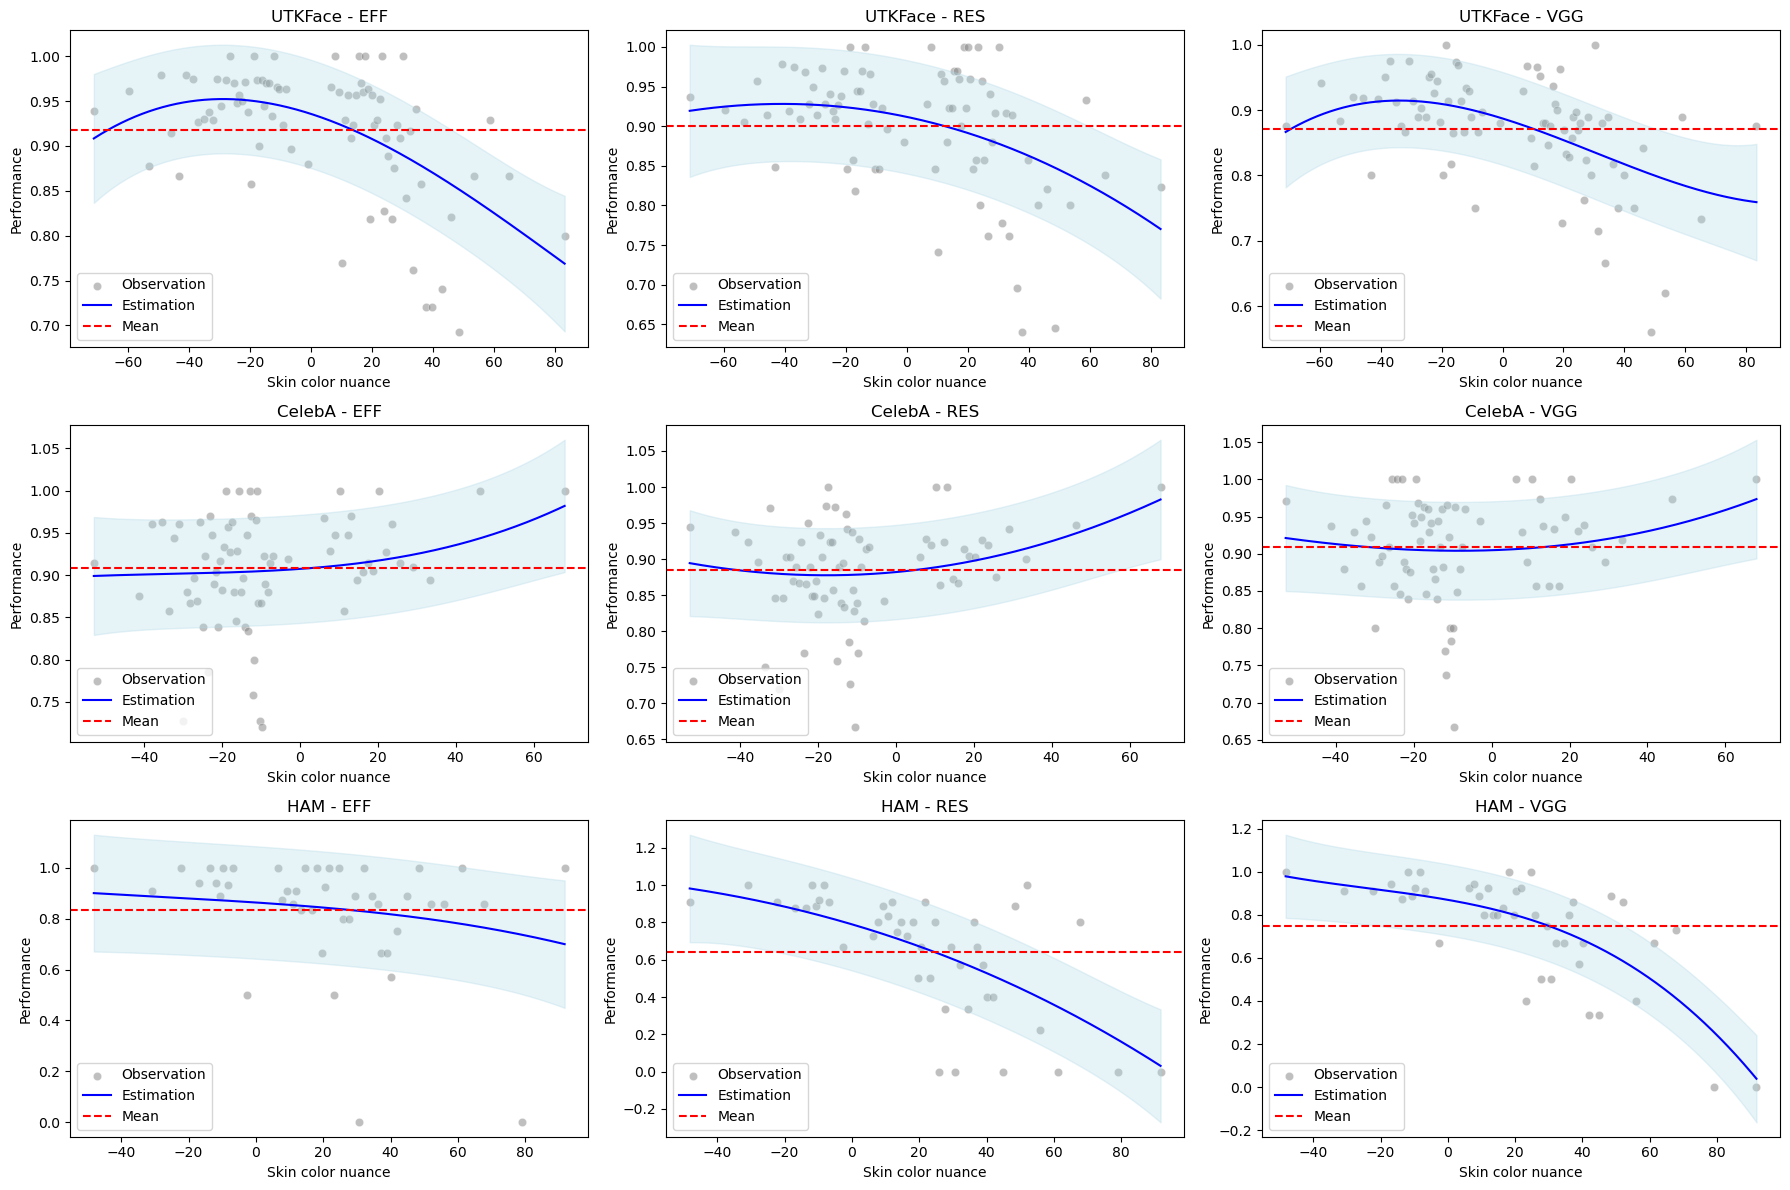

In [20]:
metric = "F1"
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

for i in range(len(db)):
    for j in range(len(models)):
        batch_size = math.ceil(length_db[db[i]] * 0.01)
        batch_size = math.ceil(batch_size / 10) * 10
        subset = df_scores[(df_scores["db"] == db[i]) & (df_scores["model"] == models[j]) & (df_scores["batch size"] == batch_size)]
        start = subset["distance"].min()
        stop = subset["distance"].max()
        num = 1500
        
        X = subset["distance"]
        y = subset[metric]
        color = "blue"
        std_color = "lightblue"
        br = BayesianRegression()
        br.fit(X, y, 3)
        br.predict(start, stop, num)
        br.display(ax[i, j], f"{db[i]} - {models[j]}", color, std_color)
        br.save_model(f"../../dataset/AAAI 2025/{db[i]}/estimator/f1_{models[j]}.pkl")

plt.tight_layout()
plt.show()